<a href="https://colab.research.google.com/github/TNCP06/Machine-Learning_Semester-5/blob/main/UTS_ML_28_Tionusa_HousePricesClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identitas:
Nama: Tionusa Catur Pamungkas

NIM: 2341720093

Kelas: 3G

Absen: 28


# House Prices — Preprocessing, Clustering (KMeans & DBSCAN), and ANN (Annoy)


In [1]:
!pip install annoy

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from annoy import AnnoyIndex

# Plot settings
%matplotlib inline
sns.set(style='whitegrid', context='notebook')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=42e20b57af3d60290878a9dca522eb2eb020d9e8af21f0993c07abc3402c4d10
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [2]:
# Upload dataset (Colab).
from google.colab import files
uploaded = files.upload()

import io, os
for fn in uploaded.keys():
    print('Uploaded file:', fn)
    df = pd.read_csv(io.BytesIO(uploaded[fn]))
print('Dataset shape:', df.shape)
df.head()


Saving train.csv to train.csv
Uploaded file: train.csv
Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:

# fitur numerik dan nilai yang hilang
numeric_df = df.select_dtypes(include=[np.number]).copy()
print('Hitung fitur numerik:', numeric_df.shape[1])
missing_counts = numeric_df.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts>0].head(20)


Hitung fitur numerik: 38


,0
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8


In [4]:

# 1. PREPROCESSING
numeric = numeric_df.copy()

if 'Id' in numeric.columns:
    numeric = numeric.drop(columns=['Id'])

target_col = 'SalePrice'
if target_col in numeric.columns:
    y = numeric[target_col].copy()
    numeric = numeric.drop(columns=[target_col])
else:
    y = None

# Imputation: menggunakan median untuk fitur numerik
imputer = SimpleImputer(strategy='median')
numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric), columns=numeric.columns)
print('Setelah imputasi, NAs?', numeric_imputed.isna().any().any())

# buat TotalArea = GrLivArea + TotalBsmtSF
if {'GrLivArea', 'TotalBsmtSF'}.issubset(numeric_imputed.columns):
    numeric_imputed['TotalArea'] = numeric_imputed['GrLivArea'] + numeric_imputed['TotalBsmtSF']
    print('Fitur TotalArea dibuat.')
else:
    print('GrLivArea atau TotalBsmtSF tidak ditemukan — melewatkan pembuatan TotalArea.')

# Scaling: gunakan StandardScaler untuk  clustering (mean=0, var=1)
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(numeric_imputed), columns=numeric_imputed.columns)
numeric_scaled.shape


Setelah imputasi, NAs? False
Fitur TotalArea dibuat.


(1460, 37)

Rasio varians yang dijelaskan (2 komponen) 0.30098007590348386


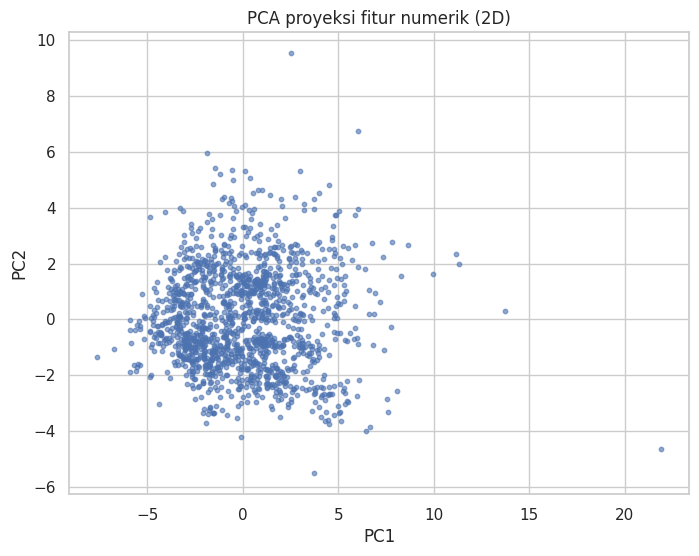

In [5]:

# PCA for visualization (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(numeric_scaled)
print('Rasio varians yang dijelaskan (2 komponen)', pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.title('PCA proyeksi fitur numerik (2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()


In [6]:

# 2. CLUSTERING KMeans
from sklearn.metrics import pairwise_distances_argmin_min

X = numeric_scaled.values

k_candidates = [3,4,5,6,7,8,9]
k_results = []

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else -1
    db = davies_bouldin_score(X, labels) if len(np.unique(labels))>1 else np.nan
    k_results.append((k, sil, db))
    print(f'K={k:2d}  Silhouette={sil:.4f}  Davies-Bouldin={db:.4f}')

k_results_df = pd.DataFrame(k_results, columns=['k','silhouette','davies_bouldin']).sort_values('silhouette', ascending=False)
k_results_df


K= 3  Silhouette=0.1382  Davies-Bouldin=2.4981
K= 4  Silhouette=0.1198  Davies-Bouldin=2.6766
K= 5  Silhouette=0.0994  Davies-Bouldin=2.4371
K= 6  Silhouette=0.0859  Davies-Bouldin=2.5648
K= 7  Silhouette=0.0916  Davies-Bouldin=2.3212
K= 8  Silhouette=0.0915  Davies-Bouldin=2.2588
K= 9  Silhouette=0.0915  Davies-Bouldin=2.2418


,k,silhouette,davies_bouldin
0,3,0.138164,2.498108
1,4,0.119764,2.676641
2,5,0.099387,2.437100
4,7,0.091626,2.321183
5,8,0.091490,2.258817
6,9,0.091480,2.241756
3,6,0.085871,2.564789


Best k by silhouette: 3


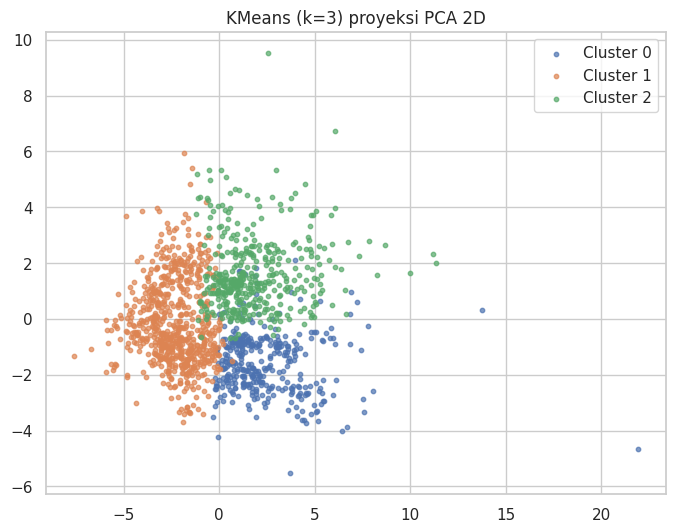

Silhouette (KMeans): 0.1381642825491246
Davies-Bouldin (KMeans): 2.498108238873369


In [7]:

# Pilih k terbaik pada silhouette dari hasil sebelumnya
best_k = int(k_results_df.iloc[0]['k'])
print('Best k by silhouette:', best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X)

# Visualize on PCA 2D
plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', n_colors=best_k)
for i in range(best_k):
    idx = (k_labels == i)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=10, alpha=0.7, label=f'Cluster {i}')
plt.legend()
plt.title(f'KMeans (k={best_k}) proyeksi PCA 2D')
plt.show()

print('Silhouette (KMeans):', silhouette_score(X, k_labels))
print('Davies-Bouldin (KMeans):', davies_bouldin_score(X, k_labels))


In [8]:

# DBSCAN clustering
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
min_samples_values = [3,5,7,10]

dbscan_results = []
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms, metric='euclidean', n_jobs=-1)
        d_labels = db.fit_predict(X)
        n_clusters = len(set(d_labels)) - (1 if -1 in d_labels else 0)
        if n_clusters <= 1:
            sil = -1
            dbi = np.nan
        else:
            sil = silhouette_score(X, d_labels)
            dbi = davies_bouldin_score(X, d_labels)
        dbscan_results.append((eps, ms, n_clusters, sil, dbi))
        print(f'eps={eps:4.2f} ms={ms:2d} clusters={n_clusters:2d} Silhouette={sil:.4f} DBI={dbi}')

dbscan_df = pd.DataFrame(dbscan_results, columns=['eps','min_samples','n_clusters','silhouette','davies_bouldin']).sort_values('silhouette', ascending=False)
dbscan_df.head(10)


eps=0.30 ms= 3 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.30 ms= 5 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.30 ms= 7 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.30 ms=10 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.50 ms= 3 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.50 ms= 5 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.50 ms= 7 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.50 ms=10 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.70 ms= 3 clusters= 1 Silhouette=-1.0000 DBI=nan
eps=0.70 ms= 5 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.70 ms= 7 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=0.70 ms=10 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=1.00 ms= 3 clusters= 4 Silhouette=-0.1493 DBI=1.1722066896664185
eps=1.00 ms= 5 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=1.00 ms= 7 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=1.00 ms=10 clusters= 0 Silhouette=-1.0000 DBI=nan
eps=1.50 ms= 3 clusters=13 Silhouette=-0.2529 DBI=1.4836453367744369
eps=1.50 ms= 5 clusters= 2 Silhouette=-0.1940 DBI=1.

,eps,min_samples,n_clusters,silhouette,davies_bouldin
12,1.0,3,4,-0.149296,1.172207
17,1.5,5,2,-0.193982,1.904875
16,1.5,3,13,-0.252901,1.483645
0,0.3,3,0,-1.000000,NaN
3,0.3,10,0,-1.000000,NaN
2,0.3,7,0,-1.000000,NaN
1,0.3,5,0,-1.000000,NaN
4,0.5,3,0,-1.000000,NaN
8,0.7,3,1,-1.000000,NaN
5,0.5,5,0,-1.000000,NaN


Best DBSCAN params: {'eps': 1.0, 'min_samples': 3.0, 'n_clusters': 4.0, 'silhouette': -0.14929576374466808, 'davies_bouldin': 1.1722066896664185}


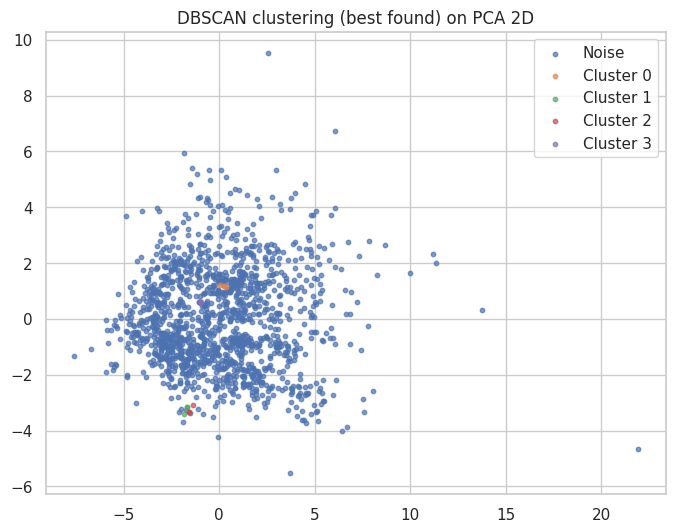

Silhouette (DBSCAN): -0.14929576374466808
Davies-Bouldin (DBSCAN): 1.1722066896664185


In [9]:

# Pilih baris DBSCAN terbaik berdasarkan silhouette
best_db = dbscan_df.dropna(subset=['silhouette']).sort_values('silhouette', ascending=False).head(1)
if best_db.shape[0] == 0 or best_db.iloc[0]['n_clusters'] <= 1:
    print('No useful DBSCAN clustering found with tested parameters.')
    best_db_params = None
else:
    best_db_params = best_db.iloc[0]
    print('Best DBSCAN params:', best_db_params.to_dict())
    db_best = DBSCAN(eps=float(best_db_params['eps']), min_samples=int(best_db_params['min_samples']), metric='euclidean', n_jobs=-1)
    db_labels = db_best.fit_predict(X)
    plt.figure(figsize=(8,6))
    unique_labels = sorted(set(db_labels))
    for lab in unique_labels:
        idx = (db_labels == lab)
        label_name = 'Noise' if lab == -1 else f'Cluster {lab}'
        plt.scatter(X_pca[idx,0], X_pca[idx,1], s=10, alpha=0.7, label=label_name)
    plt.legend()
    plt.title('DBSCAN clustering (best found) on PCA 2D')
    plt.show()
    print('Silhouette (DBSCAN):', silhouette_score(X, db_labels) if len(set(db_labels))>1 else 'N/A')
    print('Davies-Bouldin (DBSCAN):', davies_bouldin_score(X, db_labels) if len(set(db_labels))>1 else 'N/A')


In [10]:

# 3. Perkiraan Tetangga Terdekat (Annoy)
# membangun indeks Annoy pada fitur numerik berskala.
f = X.shape[1]  # feature length
ann_index = AnnoyIndex(f, 'euclidean')

# Tambahkan semua item ke indeks
for i, vec in enumerate(X):
    ann_index.add_item(i, vec.tolist())

n_trees = 10
ann_index.build(n_trees)
print('Annoy index built with', n_trees, 'trees.')

# Pilih beberapa titik queri — misalnya, beberapa pusat klaster dari KMean + beberapa titik acak
query_points = []
query_indices = []

# Gunakan pusat klaster KMeans (dalam ruang fitur berskala asli)
centers = kmeans.cluster_centers_
for i, c in enumerate(centers):
    query_points.append(c)
    query_indices.append(f'kmeans_center_{i}')

# Add a few sample points from dataset (use first 5 rows)
for i in range(min(5, X.shape[0])):
    query_points.append(X[i])
    query_indices.append(f'data_index_{i}')

# Jalankan kueri ANN dan rekam tetangga (k terdekat)
k_neigh = 10
ann_results = []
for qi, qp in enumerate(query_points):

    neighbors, distances = ann_index.get_nns_by_vector(qp.tolist(), k_neigh, include_distances=True)
    ann_results.append({
        'query_index': query_indices[qi],
        'neighbors': neighbors,
        'distances': distances
    })

# tampilkan hasil
for res in ann_results:
    print('\nQuery:', res['query_index'])
    print('Neighbors (index):', res['neighbors'])
    print('Distances:', ['{:.4f}'.format(d) for d in res['distances']])


Annoy index built with 10 trees.

Query: kmeans_center_0
Neighbors (index): [1016, 604, 476, 143, 67, 530, 683, 6, 1280, 1413]
Distances: ['1.8578', '2.2169', '2.2676', '2.3111', '2.5487', '2.5848', '2.8080', '2.8461', '2.8508', '2.8588']

Query: kmeans_center_1
Neighbors (index): [19, 97, 1436, 1249, 331, 1102, 979, 1331, 967, 361]
Distances: ['2.4785', '2.6419', '2.7733', '2.8003', '2.8012', '2.9374', '2.9473', '2.9810', '3.0112', '3.0211']

Query: kmeans_center_2
Neighbors (index): [732, 469, 1159, 506, 374, 1128, 746, 152, 147, 1300]
Distances: ['1.8586', '2.2772', '2.3271', '2.4541', '2.4602', '2.5369', '2.6057', '2.7476', '2.7616', '2.8214']

Query: data_index_0
Neighbors (index): [0, 1366, 1240, 518, 1365, 1224, 1401, 670, 1410, 94]
Distances: ['0.0000', '1.7456', '1.9618', '2.0702', '2.2105', '2.4263', '2.4623', '2.4789', '2.5565', '2.6277']

Query: data_index_1
Neighbors (index): [1, 925, 1076, 201, 892, 611, 580, 1225, 741, 717]
Distances: ['0.0000', '3.1413', '3.4349', '3.59

## Kesimpulan Analisis Clustering

Berdasarkan analisis clustering menggunakan algoritma KMeans dan DBSCAN pada data rumah yang telah dipreprocessing dan diskalakan, didapatkan hasil sebagai berikut:

**KMeans Clustering:**

*   Beberapa nilai k (jumlah cluster) diuji, yaitu 3, 4, 5, 6, 7, 8, dan 9.
*   Evaluasi dilakukan menggunakan Silhouette Score dan Davies-Bouldin Index.
*   Nilai Silhouette Score terbaik didapatkan pada k=3 dengan nilai 0.1382. Nilai Davies-Bouldin Index yang sesuai adalah 2.4981.
*   Visualisasi hasil KMeans dengan k=3 pada proyeksi PCA 2D menunjukkan pemisahan cluster yang moderat.

**DBSCAN Clustering:**

*   Beberapa kombinasi parameter eps (jarak maksimum antara dua sampel agar dianggap sebagai satu cluster) dan min\_samples (jumlah sampel dalam radius eps agar dianggap sebagai titik inti) diuji.
*   Evaluasi juga dilakukan menggunakan Silhouette Score dan Davies-Bouldin Index.
*   Hasil DBSCAN menunjukkan bahwa banyak kombinasi parameter menghasilkan 0 atau 1 cluster, atau nilai Silhouette Score yang negatif, menunjukkan kualitas clustering yang buruk atau sebagian besar data dianggap noise.
*   Kombinasi parameter terbaik yang menghasilkan lebih dari 1 cluster adalah eps=1.0 dan min\_samples=3, menghasilkan 4 cluster dengan Silhouette Score -0.1493 dan Davies-Bouldin Index 1.1722. Nilai Silhouette Score yang negatif ini mengindikasikan bahwa sampel dalam cluster sangat mirip dengan sampel dari cluster lain, atau terdapat banyak noise.

**Perbandingan:**

*   KMeans dengan k=3 memberikan hasil clustering yang lebih baik dibandingkan dengan DBSCAN berdasarkan nilai Silhouette Score (0.1382 vs -0.1493) dan visualisasi pada proyeksi PCA 2D, meskipun nilai Silhouette Score untuk KMeans masih tergolong rendah, menunjukkan bahwa cluster mungkin tidak terlalu terpisah dengan baik di ruang fitur dimensi tinggi.
*   DBSCAN tampaknya kesulitan menemukan struktur cluster yang jelas pada dataset ini dengan parameter yang diuji, dengan banyak titik yang diklasifikasikan sebagai noise (-1).

**Kesimpulan:**

Dari kedua metode clustering yang diterapkan, KMeans dengan 3 cluster memberikan hasil yang sedikit lebih menjanjikan meskipun kualitas clustering secara keseluruhan tidak optimal berdasarkan metrik evaluasi standar. Dataset ini mungkin memiliki struktur data yang kompleks atau cluster yang tumpang tindih di ruang fitur yang berskala. Analisis lebih lanjut atau penggunaan metode clustering lain mungkin diperlukan untuk mendapatkan hasil yang lebih baik.